#### Calculate ERA5 SST, RH, Vorticity  according to LMI  and their climatology
- SST
- Relative humidity at 600hPa
- relative vorticity at 850hPa  
Ming Ge June 2024

In [1]:
import os
import glob
import calendar
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from metpy.units import units

from tc_helping import hist_3, hist_4, latlon_ij, level_k

#### set up

In [2]:
# we use 2-day lag
lag = 2

#  averaging radius in degrees
rr = .5

date_format = '%Y%m%d%H'

year_s = 1990
year_e = 2020
n_year = year_e - year_s + 1

# NA region:
lat_s = 5
lat_e = 60
lon_e = -10  
lon_s = -100 

# climatology calculation only on July, Aug, Sept
months   = ['07', '08', '09']
last_day = ['31', '31', '30']
n_month = len(months)

dir_plot = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/'

#### read in lmi times/locations

In [3]:
flnm = '/glade/work/done/tc_int/Kossin_LMIs_cut.csv'
df_all = pd.read_csv(flnm, delimiter=',', engine='python')
# for northern hemisphere, July, Aug. and Sept
df_lmi = df_all.loc[(df_all.klat.values >= lat_s) & (df_all.klat.values <= lat_e) &
                    (df_all.klon.values >= lon_s) & (df_all.klon.values <= lon_e) &
                    (df_all.kmon.values >=7) & (df_all.kmon.values<=9)]
print(df_lmi.head())

yyyy = df_lmi.kyear.values 
mm   = df_lmi.kmon.values
dd   = df_lmi.kday.values
hh   = df_lmi.khour.values

yyyys = yyyy.astype(str)
mms   = mm.astype(str)
dds   = dd.astype(str)
hhs   = hh.astype(str)

ntim = len(hhs)

yyyymmddhh = [None] * ntim
date_format = '%Y%m%d%H'

yyyymmddhh  = [None] * ntim
yyyymmddhhs = [None] * ntim
for nt in range(ntim):
    current_date = datetime(yyyy[nt], mm[nt], dd[nt], hh[nt])
    
    # Calculate the date of the previous 2 days
    datetime_lagged = current_date - timedelta(days=lag)
    yyyy[nt] = datetime_lagged.year
    mm[nt]   = datetime_lagged.month
    dd[nt]   = datetime_lagged.day
    hh[nt]   = datetime_lagged.hour
    
    yyyy[nt] = str(yyyy[nt]) 
    mms[nt]  = str(mm[nt]).zfill(2)
    mms[nt]  = str(mm[nt]).zfill(2)
    dds[nt]  = str(dd[nt]).zfill(2)
    hhs[nt]  = str(hh[nt]).zfill(2)
    yyyymmddhh[nt] = int(yyyys[nt] + mms[nt] + dds[nt] + hhs[nt]) 
    yyyymmddhhs[nt] = str(yyyymmddhh[nt])
    
# E5 is on a quarter degree lat lon. Need to round to the nearest quarter to get the same dimensions for compositing.
lat = np.round(df_lmi.klat.values*4.0, 0)/4.0
lon = df_lmi.klon.values
lon = np.where(lon <= 0., lon+360., lon)
lon = np.round(lon*4.0, 0)/4.0 
vmax = df_lmi.lmi.values
'lat:', lat.min(), '-', lat.max(), 'lon:',lon.min(), '-', lon.max()

          ksid300  lmi  kyear  kmon  kday  khour   klat   klon
39  1979190N20290   35   1979     7     9     18  23.90 -71.00
40  1979191N22264   55   1979     7    11     12  29.25 -90.66
41  1979192N30280   45   1979     7    11      6  32.00 -75.90
43  1979197N13314   45   1979     7    21      0  20.45 -79.92
48  1979205N17325   35   1979     7    24     12  18.20 -42.10


('lat:', 8.75, '-', 58.5, 'lon:', 260.25, '-', 341.0)

#### 1.1 Get SST from ERA5

In [4]:
%%time
dir_sfc = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/"
dir_o = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/'
flnm_csv = dir_o + 'global_lmi_e5_lag' + str(lag) + 'd_' + str(rr) + "radius_sst_NA.csv"

if os.path.isfile(flnm_csv):
    print(flnm_csv, 'exist')
    df_sst = pd.read_csv(flnm_csv, delimiter=',', engine='python')
    sst_lmi = df_sst.sst
    print(df_sst.head())
else:
    print('output', flnm_csv)
    sst_1d = np.zeros((ntim))
    for nt in range(ntim):
        dir = dir_sfc + yyyys[nt] + mms[nt] + "/" 
        last_day_tmp = str(calendar.monthrange(int(yyyys[nt]), int(mms[nt]))[1])
        flnm = dir + "e5.oper.an.sfc.128_034_sstk.ll025sc." + yyyys[nt] + mms[nt] + "0100_" + yyyys[nt] + mms[nt] + last_day_tmp.zfill(2)+ "23.nc"
        print(nt, ntim, flnm)

        # Converting a string in a specific format to a datetime
        date_obj = datetime.strptime(yyyymmddhhs[nt], date_format)
    
        with xr.open_dataset(flnm) as ds:
            sst_1d[nt] = ds.SSTK.sel(time = date_obj,
                                 latitude=slice(lat[nt]+rr, lat[nt]-rr), 
                                 longitude=slice(lon[nt]-rr,lon[nt]+rr)).mean()
             
    data = { 'yyyymmddhh': yyyymmddhhs, 'lat': lat, 'lon': lon, 'sst': sst_1d}

    # Create the pandas DataFrame
    df = pd.DataFrame(data)
    df.to_csv(flnm_csv, float_format="%.3f", index=False) 


/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/global_lmi_e5_lag2d_0.5radius_sst_NA.csv exist
   yyyymmddhh    lat     lon      sst
0  1979070718  24.00  289.00  301.385
1  1979070912  29.25  269.25  303.622
2  1979070906  32.00  284.00  299.394
3  1979071900  20.50  280.00  302.357
4  1979072212  18.25  318.00  299.730
CPU times: user 4.27 ms, sys: 47 µs, total: 4.32 ms
Wall time: 4.33 ms


### 1.2 Calculate climatology of SST  

In [5]:
%%time

flnm = '/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/199007/e5.oper.an.sfc.128_034_sstk.ll025sc.1990070100_1990073123.nc'
i_1d, j_1d = latlon_ij([lat_s, lat_e], [lon_s+360, lon_e+360], flnm)

flnm_nc = dir_o + 'global_lmi_e5_' + str(rr) + "radius_sst_NA_July-Sep.nc"
print('output', flnm_nc)
pattern_sst = 'e5.oper.an.sfc.128_034_sstk.ll025sc*nc' 

if os.path.isfile(flnm_nc):
    print(flnm_nc, 'exist')
    sst_cli = np.zeros((ntim))

    with xr.open_dataset(flnm_nc) as ds:
        sst = ds.sst

    for nt in range(ntim):
        sst_cli[nt] = sst.sel(lat=slice(lat[nt]+rr, lat[nt]-rr), 
                        lon=slice(lon[nt]-rr,lon[nt]+rr)).mean() 
else:
    for year in range(year_s, year_e + 1):
        years = str(year)
        for nm in range(n_month):
            dir = dir_sfc + years + months[nm] + "/" 
            flnm = dir + "e5.oper.an.sfc.128_034_sstk.ll025sc." + years + months[nm] + "0100_" + years + months[nm] + last_day[nm]+ "23.nc"
            print(flnm)

            ncid = Dataset(flnm, mode='r')
            sst = (ncid.variables['SSTK'][:,i_1d[1]:i_1d[0], j_1d[0]:j_1d[1]]).mean(axis=0)
        
            if year==year_s and nm == 0:
                sst_2d = sst
                lat_cli = ncid.variables['latitude'][i_1d[1]:i_1d[0]][:]
                lon_cli = ncid.variables['longitude'][j_1d[0]:j_1d[1]][:]
            else:
                sst_2d = sst_2d +  sst
                
    sst_2d = sst_2d/(n_year*3.0) 
    data = { 'lat': lat_cli, 'lon': lon_cli, 'sst': sst_2d}

    ds = xr.Dataset({'sst': (["lat", "lon"], sst_2d)},
                 coords={"lat": lat_cli, "lon": lon_cli})    
    
    ds.to_netcdf(flnm_nc)


/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/199007/e5.oper.an.sfc.128_034_sstk.ll025sc.1990070100_1990073123.nc
output /glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/global_lmi_e5_0.5radius_sst_NA_July-Sep.nc
/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/global_lmi_e5_0.5radius_sst_NA_July-Sep.nc exist
CPU times: user 1.09 s, sys: 85.4 ms, total: 1.17 s
Wall time: 1.87 s


/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/sst_distribution_NA_3.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


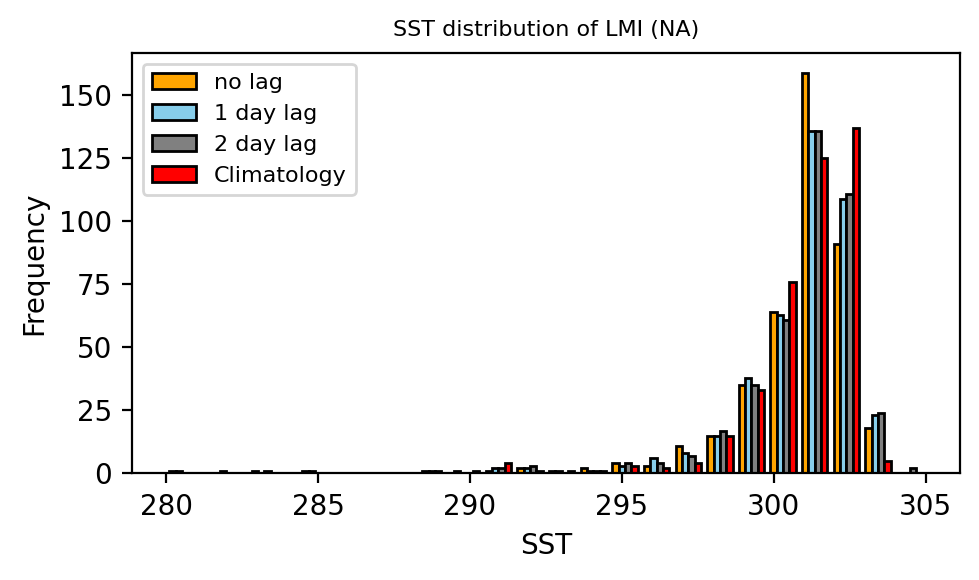

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/sst_diff_distribution_NA_3.eps


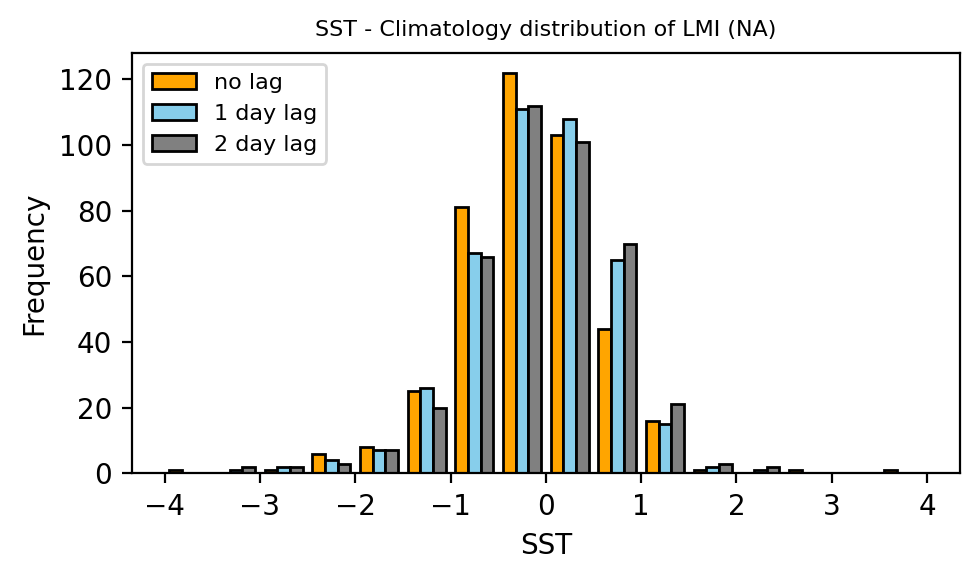

In [6]:
flnm_csv = [dir_o + 'global_lmi_e5_lag0d_0.5radius_sst_NA.csv',
            dir_o + 'global_lmi_e5_lag1d_0.5radius_sst_NA.csv',
            dir_o + 'global_lmi_e5_lag2d_0.5radius_sst_NA.csv']

data_cli = sst_cli
bins = np.linspace(280, 305, 25)
hist_4(dir_plot, dir_o, 'SST', bins, flnm_csv, sst_cli)

bins = np.linspace(-4, 4, 17)
hist_3(dir_plot, dir_o, 'SST', bins, flnm_csv, sst_cli)

#### 2.1 Calculate Relative humidity at 600hPa

In [7]:
%%time
dir_pl = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/"
#dir_o = '/glade/derecho/scratch/mingge/ERA5/'
flnm_csv = dir_o + 'global_lmi_e5_lag' + str(lag) + 'd_' + str(rr) + "radius_rh_NA.csv"
print('output', flnm_csv)

if os.path.isfile(flnm_csv):
    print(flnm_csv, 'exist')
    df_rh = pd.read_csv(flnm_csv, delimiter=',', engine='python')
    rh_lmi = df_rh.rh
    print(df_rh)
else:
    rh_1d = np.zeros((ntim))
    
    for nt in range(ntim):
        dir = dir_pl + yyyys[nt] + mms[nt] + "/" 
        # units = "kg kg**-1" 
        flnm_q = dir + "e5.oper.an.pl.128_133_q.ll025sc." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"
        # units = "K" 
        flnm_t = dir + "e5.oper.an.pl.128_130_t.ll025sc." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"

        # Converting a string in a specific format to a datetime
        date_obj = datetime.strptime(yyyymmddhhs[nt], date_format)
        with xr.open_dataset(flnm_q) as ds:
            qq = ds.Q.sel(time = date_obj, level=600)

        with xr.open_dataset(flnm_t) as ds:
            tt = ds.T.sel(time = date_obj, level=600)
         
        pres = tt.copy()
        pres[:] = 600
        rh_tmp = relative_humidity_from_specific_humidity(pres.values*units.hPa, tt, qq)    

        rh_1d[nt] = rh_tmp.sel(latitude=slice(lat[nt]+rr, lat[nt]-rr), 
                    longitude=slice(lon[nt]-rr,lon[nt]+rr)).mean()
   
    ## write out
    data = { 'yyyymmddhh': yyyymmddhh, 'lat': lat, 'lon': lon, 'rh': rh_1d}

    # Create the pandas DataFrame
    df = pd.DataFrame(data)
    df.to_csv(flnm_csv, float_format="%.3f", index=False)    
 

output /glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/global_lmi_e5_lag2d_0.5radius_rh_NA.csv
/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/global_lmi_e5_lag2d_0.5radius_rh_NA.csv exist
     yyyymmddhh    lat     lon     rh
0    1979070718  24.00  289.00  0.255
1    1979070912  29.25  269.25  0.788
2    1979070906  32.00  284.00  0.030
3    1979071900  20.50  280.00  0.611
4    1979072212  18.25  318.00  0.303
..          ...    ...     ...    ...
405  2017090500  19.25  294.00  0.328
406  2017090618  16.50  302.25  0.507
407  2017090618  21.00  263.75  0.825
408  2017092500  30.00  305.00  0.415
409  2017091800  17.00  295.75  0.668

[410 rows x 4 columns]
CPU times: user 5.7 ms, sys: 0 ns, total: 5.7 ms
Wall time: 5.71 ms


#### 2.2 Calculate climatology of RH at 100 locations

/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/rh_distribution_NA_3.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


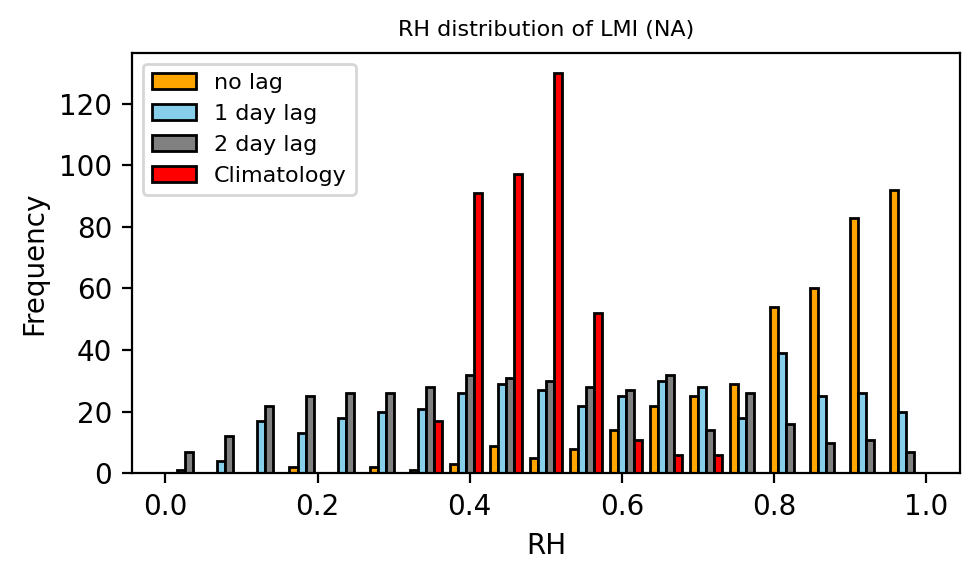

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/rh_diff_distribution_NA_3.eps


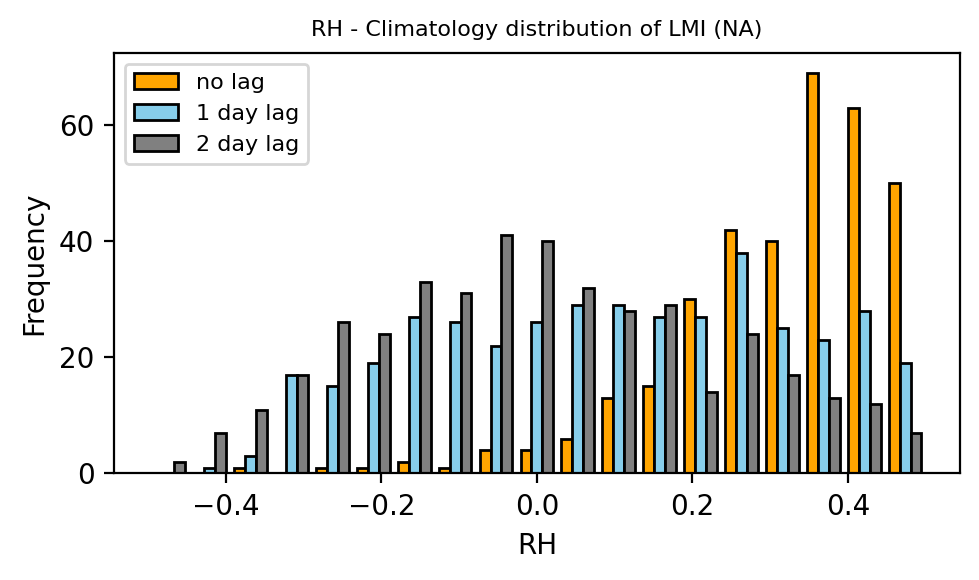

In [8]:
dir_o = '/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/'
rh_cli = np.zeros((ntim))
 
for year in range(year_s, year_e + 1):
    flnm_nc = dir_o + 'global_lmi_e5_' + str(rr) + 'radius_RH_NA_'+ str(year) +'_July-Sep.nc'
    with xr.open_dataset(flnm_nc) as ds:
        if year == year_s:
            rh_cli_2d = ds.rh
        else:
            rh_cli_2d = rh_cli_2d + ds.rh
        
rh_cli_2d = rh_cli_2d/float(n_year)

for nt in range(ntim):
    rh_cli[nt] = rh_cli_2d.sel(lat=slice(lat[nt]+rr, lat[nt]-rr), 
                        lon=slice(lon[nt]-rr,lon[nt]+rr)).mean() 

flnm_csv = [dir_o + 'global_lmi_e5_lag0d_0.5radius_rh_NA.csv',
            dir_o + 'global_lmi_e5_lag1d_0.5radius_rh_NA.csv',
            dir_o + 'global_lmi_e5_lag2d_0.5radius_rh_NA.csv']

data_cli = rh_cli
bins = np.linspace(0, 1, 20)
hist_4(dir_plot, dir_o, 'RH', bins, flnm_csv, rh_cli)

bins = np.linspace(-0.5, .5, 20)
hist_3(dir_plot, dir_o, 'RH', bins, flnm_csv, rh_cli)


#### 3.1 Relative vorticity at 850hPa

In [9]:
%%time
dir_pl = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/"
 
flnm_csv = dir_o + 'global_lmi_e5_lag' + str(lag) + 'd_' + str(rr) + "radius_vor_NA.csv"
print('output', flnm_csv)

if os.path.isfile(flnm_csv):
    print(flnm_csv, 'exist')
    df_vor = pd.read_csv(flnm_csv, delimiter=',', engine='python')
    vor_lmi = df_vor.vor
    print(df_vor.head())
else:
    vor_1d = np.zeros((ntim))
    
    for nt in range(ntim):
        dir = dir_pl + yyyys[nt] + mms[nt] + "/" 
        # units = "kg kg**-1" 
        flnm_vo = dir + "e5.oper.an.pl.128_138_vo.ll025sc." + yyyys[nt] + mms[nt] + dds[nt] + "00_" + yyyys[nt] + mms[nt] + dds[nt] + "23.nc"       
        #print(nt, ntim, flnm_vo)

        # Converting a string in a specific format to a datetime
        date_obj = datetime.strptime(yyyymmddhhs[nt], date_format)
        with xr.open_dataset(flnm_vo) as ds:
            vor_tmp = ds.VO.sel(time = date_obj, level=850)

        vor_1d[nt] = vor_tmp.sel(latitude=slice(lat[nt]+rr, lat[nt]-rr), 
                    longitude=slice(lon[nt]-rr,lon[nt]+rr)).mean()
   
    ## write out
    data = { 'yyyymmddhh': yyyymmddhh, 'lat': lat, 'lon': lon, 'vor': vor_1d}

    # Create the pandas DataFrame
    df = pd.DataFrame(data)
    df.to_csv(flnm_csv, float_format="%.6f", index=False)    


output /glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/global_lmi_e5_lag2d_0.5radius_vor_NA.csv
/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/global_lmi_e5_lag2d_0.5radius_vor_NA.csv exist
   yyyymmddhh    lat     lon       vor
0  1979070718  24.00  289.00  0.000013
1  1979070912  29.25  269.25 -0.000018
2  1979070906  32.00  284.00  0.000016
3  1979071900  20.50  280.00 -0.000002
4  1979072212  18.25  318.00 -0.000030
CPU times: user 5.32 ms, sys: 0 ns, total: 5.32 ms
Wall time: 5.43 ms


#### 3.2 Calculate climatology of relative vorticity at 100 locations

In [10]:
vor_cli = np.zeros((ntim))
 
for year in range(year_s, year_e + 1):
    flnm_nc = dir_o + 'global_lmi_e5_' + str(rr) + 'radius_vor_NA_'+ str(year) +'_July-Sep.nc'
    with xr.open_dataset(flnm_nc) as ds:
        if year == year_s:
            vor_cli_2d = ds.vorticity
        else:
            vor_cli_2d = vor_cli_2d + ds.vorticity
        
vor_cli_2d = vor_cli_2d/float(n_year)

for nt in range(ntim):
    vor_cli[nt] = vor_cli_2d.sel(lat=slice(lat[nt]+rr, lat[nt]-rr), 
                        lon=slice(lon[nt]-rr,lon[nt]+rr)).mean() 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/vor_distribution_NA_3.eps


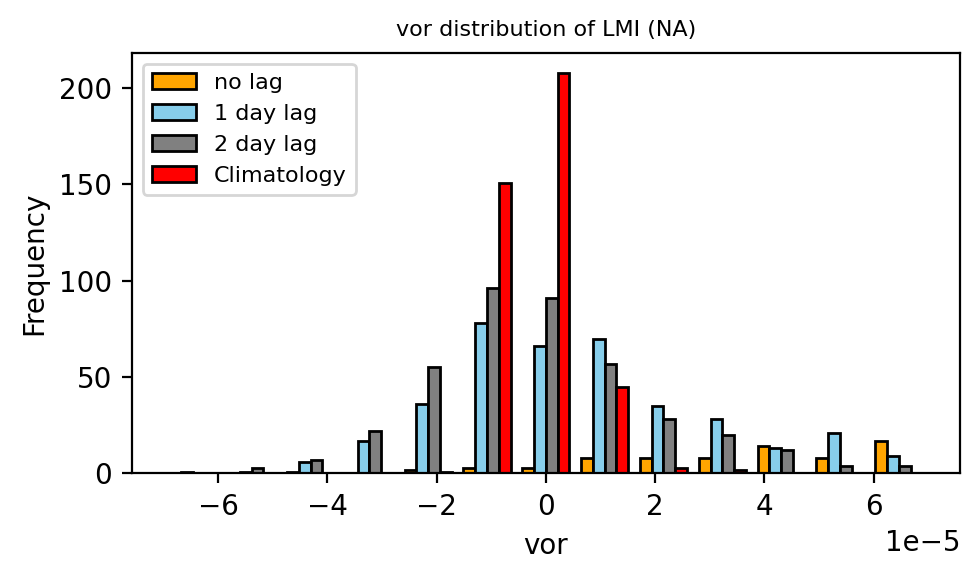

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/vor_diff_distribution_NA_3.eps


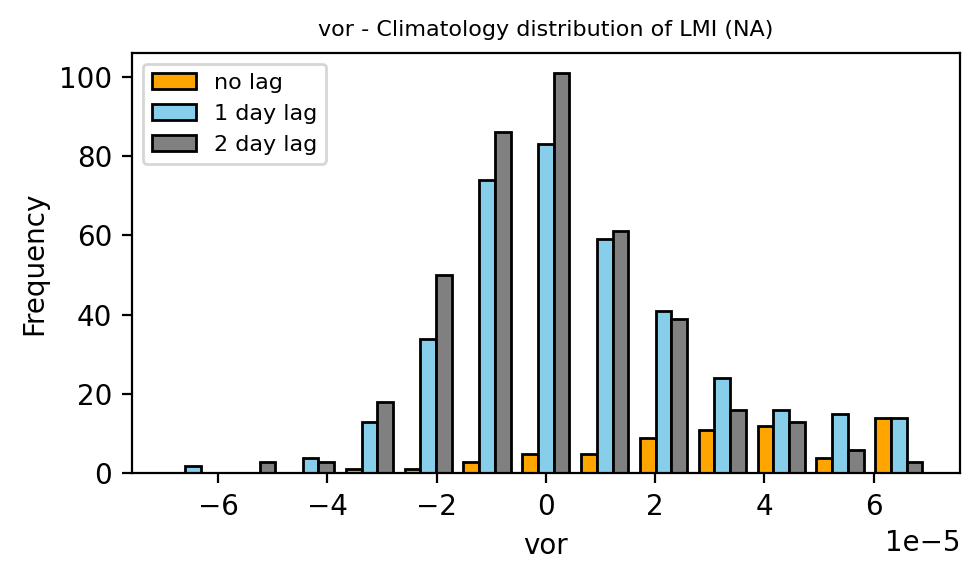

In [11]:
flnm_csv = [dir_o + 'global_lmi_e5_lag0d_0.5radius_vor_NA.csv',
            dir_o + 'global_lmi_e5_lag1d_0.5radius_vor_NA.csv',
            dir_o + 'global_lmi_e5_lag2d_0.5radius_vor_NA.csv']

data_cli = rh_cli
bins = np.linspace(-0.00007, 0.00007, 14)
hist_4(dir_plot, dir_o, 'vor', bins, flnm_csv, vor_cli)
hist_3(dir_plot, dir_o, 'vor', bins, flnm_csv, vor_cli)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/vorticity850_distribution_NA.eps


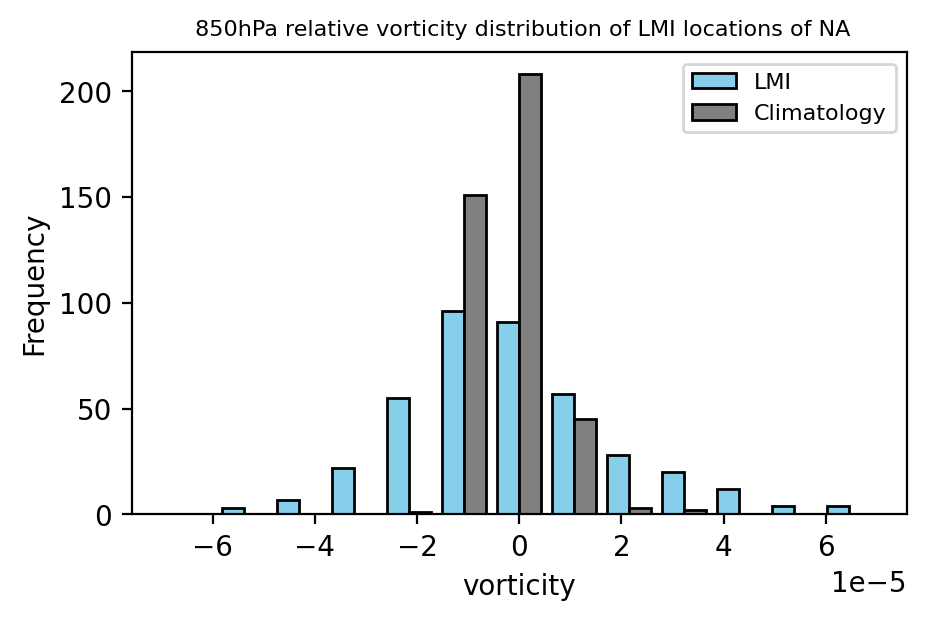

In [29]:

# Plotting a basic histogram
flnm_p = dir_plot + 'vorticity850_distribution_NA.eps'
print(flnm_p)
dpi = 200

fig = plt.figure(figsize=(5, 3), dpi = dpi)
bins = np.linspace(-0.00007, 0.00007, 14)
plt.hist([vor_lmi, vor_cli], bins, label=['LMI', 'Climatology'], color=['skyblue', 'grey'], edgecolor='black')
 
# Adding labels and title
plt.xlabel('vorticity')
plt.ylabel('Frequency')
plt.title(' 850hPa relative vorticity distribution of LMI locations of NA', fontsize=8)
plt.legend(loc='upper right', fontsize=8) 
plt.savefig(flnm_p, dpi=fig.dpi, bbox_inches='tight')
plt.show()        

/glade/campaign/mmm/c3we/mingge/ERA5/NA_CLI/PLOT/vorticity850dif_distribution_NA.eps


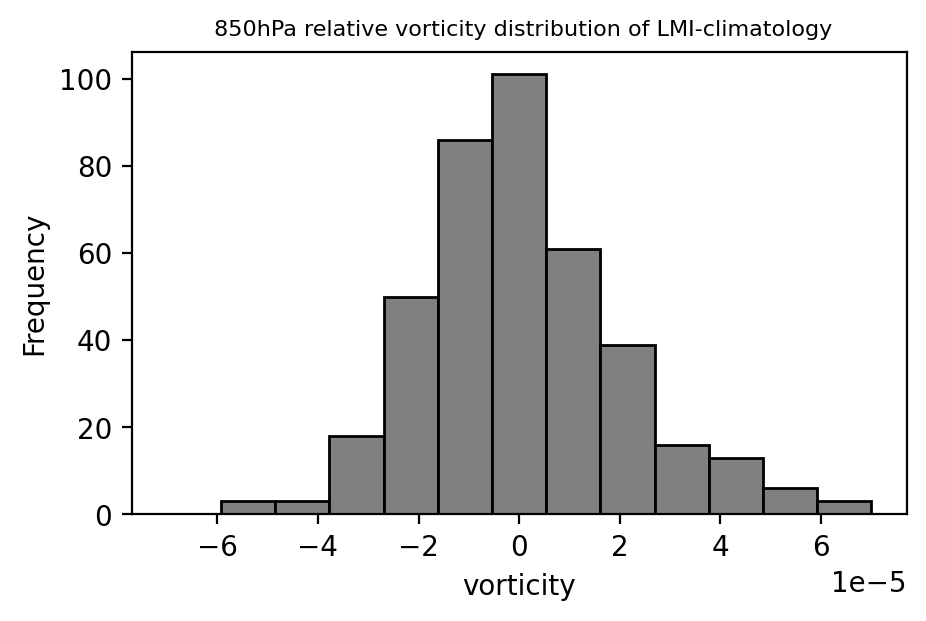

In [26]:
# Plotting a basic histogram
flnm_p = dir_plot + 'vorticity850dif_distribution_NA.eps'
print(flnm_p)
dpi = 200

fig = plt.figure(figsize=(5, 3), dpi = dpi)
bins = np.linspace(-0.00007, 0.00007, 14)
plt.hist([vor_lmi-vor_cli], bins, label=['LMI-Climatology'], color=['grey'], edgecolor='black')
 
# Adding labels and title
plt.xlabel('vorticity')
plt.ylabel('Frequency')
plt.title(' 850hPa relative vorticity distribution of LMI-climatology', fontsize=8)
#plt.legend(loc='upper right', fontsize=8) 
plt.savefig(flnm_p, dpi=fig.dpi, bbox_inches='tight')
plt.show()        